In [1]:
import pyslim, tskit, msprime
from IPython.display import SVG
import numpy as np
import pandas as pd 
import os

(sec_vignette_parallel)=


# Vignette: Parallelizing SLiM simulations in a phylogenetic tree

Imagine you want to simulate the evolutionary history of a group. If there is
no migration between any of the branches in your tree, any branches stemming
from the same node can be simulated in parallel (see {numref}`phylo`).

```{figure} _static/phylo.png
:height: 200px
:name: phylo

Example of phylogeny we might want to simulate. Note how branches with the same color can be simulated in parallel when there is no migration.
```

To do this, we'll need to do two things:
(1) be able to *simulate* branches in parallel, and
(2) glue the resulting simulations (one per tip) back together.


## Simulating the branches

First, we need to write a SLiM script that will be used for simulating the
history of each branch in our phylogeny.
We will perform a simple simulation, in which each branch can have a different
(but fixed) population size and length (number of ticks).
Also, we will allow deleterious mutations to happen across the entire chromosome
at a fixed rate.

Here is a SLiM script that would do this:

```{literalinclude} phylo_bgs.slim
```

For each branch, the presence or absence of ``infile`` tells SLiM
whether we want to start it from a previous branch or not.
If so, SLiM will read the previous tree sequence and change the
population size accordingly.
Note that when you read a tree sequence into SLiM, the tick counter will
be updated with the time encoded in the tree sequence, so we need to set the end
of the simulation as the length of the branch (`num_gens`) plus the current
"time" at the end of the loaded tree sequence.
At the end of the simulation, we call `sim.treeSeqRememberIndividuals` right
before saving the resulting tree sequence. This is necessary because we need to
ensure the individuals in the final generation are never dropped from the tree
sequence in future runs of SLiM which are started from the output of the
simulation, as they will later be used to glue the tree sequences together.

I encoded the phylogeny we will simulate in a simple table,
which we'll use as ``df`` in the code below:

In [2]:
df = pd.read_csv("_static/phylo.tsv", sep="\t")
df = df.fillna('')
df["infile"] = df.parent + ".trees"
df["outfile"] = df.child + ".trees"
df.loc[df["infile"]==".trees", "infile"] = ""
df["is_leaf"] = ~df.child.isin(df.parent)
df

,child,parent,popsize,edgelen,infile,outfile,is_leaf
0,root,,500,2000,,root.trees,False
1,C,root,50,250,root.trees,C.trees,True
2,I,root,100,200,root.trees,I.trees,False
3,B,I,70,50,I.trees,B.trees,True
4,A,I,40,50,I.trees,A.trees,True


With our phylogeny and the simulation parameters, we are ready to run our
simulations.
One way to parallelize the simulation of sister branches is to use `make`.
You do not need to know much about this tool (though it is totally worthwhile
to check it out).
The main idea here is that you can specify dependency between files and `make`
works its magic to run the simulations in the right order.
Here is python code that will write out a makefile from the information in ``df``:

In [3]:
f = open("sims.make", "w")
print(f"all: {' '.join(df.outfile.to_list())}\n", file=f)
for i, row in df.iterrows():
    print(f"{row.outfile}: {row.infile} phylo_bgs.slim", file=f)
    print(f"\tslim -d \"infile='{row.infile}'\" -d popsize={row.popsize} "
          f"-d \"popname=\'{row.child}\'\" "
          f"-d num_gens={row.edgelen} " f"-d \"outfile='{row.child}.trees'\" "
          "phylo_bgs.slim\n",
          file=f)
f.close()

Here's the result. Again, don't worry about the details,
but you can see that the file encodes the phylogeny
through a bunch of ``child : parent`` "rules":

In [4]:
%%bash
cat sims.make

all: root.trees C.trees I.trees B.trees A.trees


root.trees:  phylo_bgs.slim


	slim -d "infile=''" -d popsize=500 -d "popname='root'" -d num_gens=2000 -d "outfile='root.trees'" phylo_bgs.slim


C.trees: root.trees phylo_bgs.slim


	slim -d "infile='root.trees'" -d popsize=50 -d "popname='C'" -d num_gens=250 -d "outfile='C.trees'" phylo_bgs.slim


I.trees: root.trees phylo_bgs.slim


	slim -d "infile='root.trees'" -d popsize=100 -d "popname='I'" -d num_gens=200 -d "outfile='I.trees'" phylo_bgs.slim


B.trees: I.trees phylo_bgs.slim


	slim -d "infile='I.trees'" -d popsize=70 -d "popname='B'" -d num_gens=50 -d "outfile='B.trees'" phylo_bgs.slim


A.trees: I.trees phylo_bgs.slim


	slim -d "infile='I.trees'" -d popsize=40 -d "popname='A'" -d num_gens=50 -d "outfile='A.trees'" phylo_bgs.slim


With the makefile in hand,
we can now run make, specifying the maximum number of simulations
to be run simultaneously the ``-j``.
(Click on the "+" icon to see SLiM's output.)

In [5]:
%%bash
make -f sims.make -j 3

make[1]: Entering directory '/home/runner/work/tskit-site/tskit-site/docs'


make[1]: Nothing to be done for 'all'.


make[1]: Leaving directory '/home/runner/work/tskit-site/tskit-site/docs'


```{dropdown} Click here for how to use python instead of make

You would have to write a recursion over the branches in your tree (starting 
from the root) and then parallelize the runs of sister branches somehow.

```python
def phylo_recursion(parent, df):
    print(parent)
    childs = df[df.parent==parent]
    print(childs)
    if len(childs) == 0:
        return
    # you could parallelize this loop over childs with same parent
    for i, row in childs.iterrows():
        if not os.path.exists(row.outfile):
            os.system(f"slim -d \"infile='{row.infile}'\" -d popsize={row.popsize} -d num_gens={row.edgelen} -d \"outfile='{row.child}.trees'\" phylo_bgs.slim")
            phylo_recursion(row.child, df)

phylo_recursion("", df)
```

## Putting it all together: unioning the tree sequences

With the tree sequences in hand, we now need to glue them together.
This can be done using
[**union**](https://tskit.dev/tskit/docs/stable/python-api.html#tskit.TreeSequence.union)
from tskit.
For two tree sequences which share some of its past history is shared, **union**
works by copying the non-shared parts of one of the tree sequence onto the other.
The trickiest part of this operation is defining the parts that are equivalent
in the two tree sequences. For that, you will have to create an array that serves
as a map of node IDs between the two tree sequences.

Here is a function that will construct a map of the node IDs of two SLiM tree sequences 
that correspond to the same chromosomes in SLiM
at any time older than the given time ago at which the two populations split.
Given two tree sequences ``other`` and ``ts``,
the goal here is to find,
for each node born before ``split_time`` ago in ``other``,
the matching node in ``ts``, where we can identify matching using the SLiM ID in metadata.
The code could be made easier to read by iterating over nodes,
but the following numpy-based version is much faster:

In [6]:
def match_nodes(other, ts, split_time):
    """
    Given SLiM tree sequences `other` and `ts`, builds a numpy array with length
    `other.num_nodes` in which the indexes represent the node id in `other` and the
    entries represent the equivalent node id in `ts`. If a node in `other` has no
    equivalent in `ts`, then the entry takes the value `tskit.NULL` (-1). The
    matching is done by comparing the IDs assigned by SLiM which are kept in
    node metadata. This matching of SLiM IDs is *only* done for nodes with time
    older than the specified `split_time`.
    """
    node_mapping = np.full(other.num_nodes, tskit.NULL)
    sids0 = np.array([n.metadata["slim_id"] for n in ts.nodes()])
    sids1 = np.array([n.metadata["slim_id"] for n in other.nodes()])
    alive_before_split1 = (other.tables.nodes.time >= split_time)
    is_1in0 = np.isin(sids1, sids0)
    both = np.logical_and(alive_before_split1, is_1in0)
    sorted_ids0 = np.argsort(sids0)
    matches = np.searchsorted(
        sids0,
        sids1[both],
        side='left',
        sorter=sorted_ids0
    )
    node_mapping[both] = sorted_ids0[matches]
    return node_mapping

Now we are finally ready to **union** our tree sequences. For that, I wrote a
recursive function that goes through our data frame with the phylogeny and
returns a dictionary with the merged tree sequences from the tip to the root.

In [7]:
merged = {
    row.child : {
        "ts": tskit.load(row.outfile),
        "depth": row.edgelen,
        "children": [row.child]
    }
    for i, row in df[df.is_leaf].iterrows()
}

def union_children(parent, df, merged):
    print(f"Going in: {parent}")
    child_rows = df[df.parent == parent]
    assert (len(child_rows) == 2) or (len(childs) == 0)
    if len(child_rows) == 2:
        children = [row.child for _, row in child_rows.iterrows()]
        for child in children:
            if child not in merged:
                union_children(child, df, merged)
        split_time = merged[children[0]]["depth"]
        assert split_time == merged[children[1]]["depth"] # ultrametric
        print(f'Unioning: {children}, Split time: {split_time}')
        ts0 = merged[children[0]]["ts"]
        ts1 = merged[children[1]]["ts"]
        node_map = match_nodes(ts1, ts0, split_time)
        tsu = ts0.union(ts1, node_map, check_shared_equality=True)
        # the time from tip to start of simulation is split_time plus the
        # length of the edge
        parent_edgelength = df[df.child==parent].edgelen.item()
        merged[parent] = {
            "ts": tsu,
            "depth": split_time + parent_edgelength,
            "children": merged[children[0]]["children"] + merged[children[1]]["children"]
        }

union_children("root", df, merged)
# union of all three species tree sequences is in the root.
tsu = merged["root"]["ts"]
pops = merged["root"]["children"]

Going in: root
Going in: I
Unioning: ['B', 'A'], Split time: 50
Unioning: ['C', 'I'], Split time: 250


A slightly tricky thing we had to do there was to make sure we kept track of
which population in the union'ed tree sequence corresponds to
which population in our phylogeny.
Happily, we've stored each population's name in its metadata field,
so it's easy to match populations in the tree sequence up to what they're supposed to be.

Let's make sure we have the right number of present-day samples
in each of the populations. To do this we need to make sure to get
"alive" samples, because recall that we have saved the state of the
population at each species split time.

In [8]:
alive = np.where(np.isclose(tsu.tables.nodes.time, 0))[0]
pop_ids = {}
for pop in tsu.populations():
    if pop.metadata is not None:
        pop_ids[pop.metadata['name']] = pop.id

for name in pops:
    pop_samples = tsu.samples(pop_ids[name])
    n_samples = sum(np.isin(pop_samples, alive)) // 2
    print(f"Union-ed tree sequence has {n_samples} samples in population {name},\n"
          f"\tand we specified {df[df.child==name].popsize.item()} individuals in our simulations.")
    assert n_samples == df[df.child==name].popsize.item()

Union-ed tree sequence has 50 samples in population C,
	and we specified 50 individuals in our simulations.
Union-ed tree sequence has 70 samples in population B,
	and we specified 70 individuals in our simulations.
Union-ed tree sequence has 40 samples in population A,
	and we specified 40 individuals in our simulations.


Let's do an additional consistency check now, to see if we need to recapitate
(i.e., if some trees haven't coalesced),
and to make sure that all roots are in the root population,
as they should be:

In [9]:
# TODO: fix up
# for t in tsu.trees():
#     for r in t.roots:
#         assert tsu.node(r).population == pop_ids["root"]

print(f"Max number of roots: {max([t.num_roots for t in tsu.trees()])}.")

Max number of roots: 1.


Finally, we will recapitate the result with a small population size of 100,
in case some trees on the root branch haven't coalesced,
and write out the result:

In [10]:
tsu = pyslim.recapitate(tsu, recombination_rate=1e-8, ancestral_Ne=100)
tsu.dump("final.trees")

/opt/hostedtoolcache/Python/3.8.13/x64/lib/python3.8/site-packages/msprime/ancestry.py:831: TimeUnitsMismatchWarning: The initial_state has time_units=ticks but time is measured in generations in msprime. This may lead to significant discrepancies between the timescales. If you wish to suppress this warning, you can use, e.g., warnings.simplefilter('ignore', msprime.TimeUnitsMismatchWarning)
  warnings.warn(message, TimeUnitsMismatchWarning)


Now we're done, and can analyse the final tree sequence!
Just for fun, I'll look at the trees produced by the simulation.
For instance, we might be curious how often there are
disagreements between the species tree and the simulated gene trees
(also called incomplete lineage sorting, or ILS).

To make it possible to look at the trees,
I will first simplify the union-ed tree sequence to keep only two diploid
samples per population.

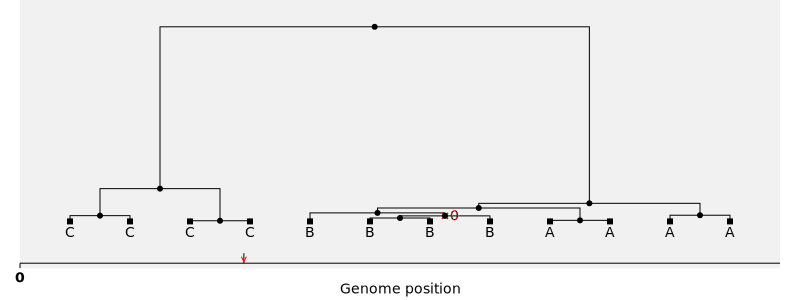

In [11]:
rng = np.random.default_rng(seed=123)
ind_alive = pyslim.individuals_alive_at(tsu, 0)
# TODO: this will work in the next tskit
# ind_pops = tsu.individuals_population[ind_alive]
ind_pops = np.array([tsu.node(tsu.individual(i).nodes[0]).population for i in ind_alive])
subsample_indivs = [
    rng.choice(ind_alive[ind_pops == pop_ids[name]], 2)
    for name in pops
]
subsample_nodes = [
    np.concatenate([tsu.individual(i).nodes for i in x])
    for x in subsample_indivs
]
tsus = tsu.simplify(
        np.concatenate(subsample_nodes),
        filter_populations=False,
)
pop_labels = {v: k for k, v in pop_ids.items()}
SVG(tsus.draw_svg(
    node_labels={
        node.id: pop_labels[node.population]
        for node in tsus.nodes()
        if not node.time > 0.0
    },
    x_lim=[0,2200],
    size=(800, 300),
))

:::{note}
A possible gotcha in the code above lies in getting the time units to work out.
Note that in the SLiM script we both save and reload .trees files in the
``late()`` stage of the SLiM life cycle. This is important: if we had reloaded the
files in ``early()``, then each time we did so the "tskit time" and "SLiM time"
would become one step out of sync. This leads to errors either in union (since
if the time units in the two tree sequences do not match, union will raise an error)
or in recapitate (since recapitate assumes that the "top" of the trees are at
the number of generations ago recorded by SLiM in metadata).
:::